In [144]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [145]:
def quarter_end_from_year_quarter(year: int, quarter: str) -> pd.Timestamp:
    q = quarter.upper().strip().replace(" ", "")
    if q not in {"Q1", "Q2", "Q3", "Q4"}:
        raise ValueError("Quarter must be one of: Q1, Q2, Q3, Q4")
    q_num = int(q[1])
    return pd.Period(f"{year}Q{q_num}", freq="Q").to_timestamp("Q")


Our engine is quarterly. This converts user inputs like (2025, "Q1") into the quarter-end timestamp (e.g., 2025-03-31).
We use quarter-end consistently to align msci and your fund panel.

In [146]:
def load_msci_quarterly(msci_xlsx_path: str) -> pd.DataFrame:
    """
    Reads msci.xlsx with columns: Date, SCXP Index
    Returns quarterly series:
      quarter_end, index_level, msci_ret_q
    """
    msci = pd.read_excel(msci_xlsx_path)

    # Defensive column check
    if "Date" not in msci.columns or "SCXP Index" not in msci.columns:
        raise ValueError("msci.xlsx must contain columns: 'Date' and 'SCXP Index'")

    msci = msci[["Date", "SCXP Index"]].copy()
    msci["Date"] = pd.to_datetime(msci["Date"], errors="coerce")
    msci["SCXP Index"] = pd.to_numeric(msci["SCXP Index"], errors="coerce")
    msci = msci.dropna(subset=["Date", "SCXP Index"]).sort_values("Date")

    # Convert each observation to its quarter-end
    msci["quarter_end"] = msci["Date"].dt.to_period("Q").dt.to_timestamp("Q")

    # Quarterly level = last value observed in that quarter
    q = (msci.groupby("quarter_end", as_index=False)["SCXP Index"]
         .last()
         .rename(columns={"SCXP Index": "index_level"})
         .sort_values("quarter_end")
         .reset_index(drop=True))

    # Quarterly return
    q["msci_ret_q"] = q["index_level"].pct_change()
    q = q.dropna(subset=["msci_ret_q"]).reset_index(drop=True)

    return q


We transform daily/monthly msci into a quarterly time series:

Map each row to a quarter_end

Take the last index level within each quarter

Compute quarterly returns using % change

This gives the clean input the regime model needs.

In [147]:
def label_regimes_by_quantiles(q_returns: pd.Series, low_q=0.33, high_q=0.67) -> pd.Series:
    """
    bear if return <= q_low
    bull if return >= q_high
    flat otherwise
    """
    q_low = q_returns.quantile(low_q)
    q_high = q_returns.quantile(high_q)

    regime = pd.Series(index=q_returns.index, dtype="object")
    regime[q_returns <= q_low] = "bear"
    regime[q_returns >= q_high] = "bull"
    regime[(q_returns > q_low) & (q_returns < q_high)] = "flat"
    return regime


We need regime “states” for a Markov chain.
This first version uses a simple and robust approach:

bottom third of returns → bear

top third of returns -> bull

middle third -> flat

Later we can replace this with an HMM, but quantiles are a great baseline.

In [148]:
def estimate_transition_matrix(regimes: pd.Series, states=("bear", "flat", "bull"), laplace=1.0) -> pd.DataFrame:
    """
    P[s->s'] = counts / row-sum, with Laplace smoothing to avoid zeros.
    """
    states = list(states)
    counts = pd.DataFrame(0.0, index=states, columns=states)

    r = regimes.dropna().tolist()
    for a, b in zip(r[:-1], r[1:]):
        if a in states and b in states:
            counts.loc[a, b] += 1.0

    # Laplace smoothing: avoids zero probabilities
    counts = counts + laplace

    # Normalize each row
    P = counts.div(counts.sum(axis=1), axis=0)
    return P

This learns how regimes transition from quarter to quarter:

From historical regime labels, count transitions (bear->bull, flat->flat, etc.)

Convert counts to probabilities (rows sum to 1)

Laplace smoothing prevents “impossible” transitions due to small samples.

In [149]:
def estimate_regime_params(df_q: pd.DataFrame, states=("bear", "flat", "bull")) -> pd.DataFrame:
    """
    For each regime: mean and std of quarterly returns.
    """
    out = []
    overall_sigma = float(df_q["msci_ret_q"].std(ddof=1))
    overall_sigma = max(overall_sigma, 1e-6)

    for s in states:
        sub = df_q.loc[df_q["regime"] == s, "msci_ret_q"].dropna()
        mu = float(sub.mean()) if len(sub) else 0.0
        sigma = float(sub.std(ddof=1)) if len(sub) > 1 else overall_sigma
        sigma = max(sigma, 1e-6)
        out.append((s, mu, sigma))

    return pd.DataFrame(out, columns=["regime", "mu_q", "sigma_q"]).set_index("regime")


Estimate return distribution per regime (μ, σ)

Once we have regimes, we estimate:

mu_q[regime] = average quarterly return in that regime

sigma_q[regime] = volatility of quarterly return in that regime

In the simulation, returns are generated as:
return_t = mu_q[regime_t] + sigma_q[regime_t] * Normal(0,1).

In [150]:
def apply_persistence_tilt(P: pd.DataFrame, scenario: str, k: float = 1.5) -> pd.DataFrame:
    """
    Adjust transition probabilities so the chain spends more time in bull or bear.
    - neutral: no change
    - bullish: boost transitions INTO bull and bull self-persistence
    - bearish: boost transitions INTO bear and bear self-persistence
    """
    scenario = scenario.lower().strip()
    if scenario not in {"bullish", "neutral", "bearish"}:
        raise ValueError("scenario must be one of: bullish, neutral, bearish")

    if scenario == "neutral":
        return P.copy()

    target = "bull" if scenario == "bullish" else "bear"

    P2 = P.copy()
    # Boost probability of moving into target regime from any current regime
    for s in P2.index:
        P2.loc[s, target] *= k

    # Boost persistence once in the target regime
    P2.loc[target, target] *= k

    # Renormalize rows
    P2 = P2.div(P2.sum(axis=1), axis=0)
    return P2


Scenario tilt (bullish/neutral/bearish)

This is user control.

Instead of “forcing high returns,” we tilt the regime probabilities:

Bullish scenario -> chain more often transitions into bull and stays there

Bearish scenario -> chain more often transitions into bear and stays there

Neutral -> estimated transition matrix unchanged

This is a principled way to express a macro view.

In [151]:
def simulate_markov_regimes(P: pd.DataFrame, start_state: str, n_steps: int, rng: np.random.Generator) -> list:
    states = list(P.index)
    if start_state not in states:
        start_state = "flat" if "flat" in states else states[0]

    path = [start_state]
    for _ in range(n_steps):
        cur = path[-1]
        probs = P.loc[cur].values.astype(float)
        nxt = rng.choice(states, p=probs)
        path.append(nxt)
    return path[1:]  # length n_steps


Simulate regimes from the Markov chain

Given a transition matrix P, we simulate a regime path like:

flat -> bull -> bull -> bear -> flat -> ...

This produces the “state process” that drives returns.

In [152]:
def project_msci(
    df_q_hist: pd.DataFrame,
    start_quarter_end: pd.Timestamp,
    n_quarters: int = 40,
    low_q: float = 0.33,
    high_q: float = 0.67,
    laplace: float = 1.0,
    seed: int = 1234,
    scenario: str = "neutral",
    tilt_strength: float = 1.2,
):
    rng = np.random.default_rng(seed)

    # 1) Label regimes on history
    df = df_q_hist.copy().sort_values("quarter_end").reset_index(drop=True)
    df["regime"] = label_regimes_by_quantiles(df["msci_ret_q"], low_q=low_q, high_q=high_q)

    # 2) Fit Markov matrix + return params
    P = estimate_transition_matrix(df["regime"], laplace=laplace)
    params = estimate_regime_params(df)

    # 3) Apply scenario tilt (NEW)
    P_tilted = apply_persistence_tilt(P, scenario=scenario, k=tilt_strength)

    # 4) Find start level (must exist at start quarter or fallback to last before)
    hist_levels = df_q_hist[["quarter_end", "index_level"]].drop_duplicates("quarter_end").sort_values("quarter_end")

    if start_quarter_end not in set(hist_levels["quarter_end"]):
        prev = hist_levels.loc[hist_levels["quarter_end"] < start_quarter_end]
        if prev.empty:
            raise ValueError("Start quarter is before the first msci quarter in the file.")
        start_quarter_end = prev["quarter_end"].iloc[-1]

    start_level = float(hist_levels.loc[hist_levels["quarter_end"] == start_quarter_end, "index_level"].iloc[0])

    # Start regime = last labeled regime up to start quarter
    df_reg = df.loc[df["quarter_end"] <= start_quarter_end].dropna(subset=["regime"])
    start_regime = df_reg["regime"].iloc[-1] if not df_reg.empty else "flat"

    # 5) Future quarter-end grid
    future_qe = pd.period_range(
        start=start_quarter_end.to_period("Q") + 1,
        periods=n_quarters,
        freq="Q"
    ).to_timestamp("Q")

    # 6) Simulate regimes then returns then index levels
    regime_path = simulate_markov_regimes(P_tilted, start_regime, n_quarters, rng)

    rets, levels = [], []
    level = start_level
    for s in regime_path:
        mu = float(params.loc[s, "mu_q"])
        sig = float(params.loc[s, "sigma_q"])
        r = mu + sig * rng.standard_normal()
        level *= (1.0 + r)
        rets.append(r)
        levels.append(level)

    proj = pd.DataFrame({
        "quarter_end": future_qe,
        "regime": regime_path,
        "msci_ret_q": rets,
        "index_level": levels,
        "scenario": scenario
    })

    # Return everything explicitly (no attrs, so Parquet-safe if you choose to save)
    return proj, P, P_tilted, params


Project msci forward (main engine function)

This is the full projection engine:

Builds quarterly msci returns

Labels regimes in history

Fits a Markov chain + regime μ/σ

Applies the scenario tilt (bullish/neutral/bearish)

Simulates regimes and returns for n_quarters

Builds projected index levels

We return:

proj = projection path

P = baseline transition matrix (neutral)

P_tilted = scenario-adjusted matrix

params = μ/σ per regime

In [153]:
year = int(input("Enter year (e.g. 2025): ").strip())
quarter = input("Enter quarter (Q1, Q2, Q3, Q4): ").strip().upper()

n_q = int(input("Enter number of quarters to project (0 => default 40): ").strip() or "0")
if n_q == 0:
    n_q = 40

scenario = input("Scenario (bullish / neutral / bearish) [neutral]: ").strip().lower()
if scenario == "":
    scenario = "neutral"

BASE_DIR = os.path.join(
    "C:\\Users",
    os.environ.get("USERNAME"),
    "Documents",
    "Equity"
)

HOME = os.path.join(BASE_DIR, f"{year}_{quarter}")
DATA_DIR = os.path.join(HOME, "data")

data_csv = os.path.join(DATA_DIR, "data.csv")
if not os.path.exists(data_csv):
    raise FileNotFoundError(f"Cannot project: missing prepared dataset: {data_csv}")

msci_xlsx = os.path.join(DATA_DIR, "msci.xlsx")
if not os.path.exists(msci_xlsx):
    raise FileNotFoundError(f"Missing msci.xlsx at: {msci_xlsx}")

start_qe = quarter_end_from_year_quarter(year, quarter)

df_q_hist = load_msci_quarterly(msci_xlsx)

proj, P_neutral, P_scenario, params = project_msci(
    df_q_hist=df_q_hist,
    start_quarter_end=start_qe,
    n_quarters=n_q,
    seed=1234,
    scenario=scenario,
    tilt_strength=1.2
)

# --- Save outputs (optional) ---
save = input("Save projection files? (y/n) [y]: ").strip().lower()
if save in {"", "y", "yes"}:
    out_csv = os.path.join(DATA_DIR, f"msci_projection_{year}_{quarter}_{scenario}_{n_q}q.csv")
    proj.to_csv(out_csv, index=False)

    # Save diagnostics too (recommended)
    P_neutral.to_csv(os.path.join(DATA_DIR, f"msci_transition_neutral_{year}_{quarter}.csv"))
    P_scenario.to_csv(os.path.join(DATA_DIR, f"msci_transition_{scenario}_{year}_{quarter}.csv"))
    params.to_csv(os.path.join(DATA_DIR, f"msci_regime_params_{year}_{quarter}.csv"))

    print("Saved:")
    print(out_csv)

    out_parquet = os.path.join(DATA_DIR, f"msci_projection_{year}_{quarter}_{scenario}_{n_q}q.parquet")
    proj.to_parquet(out_parquet, index=False)
    print(out_parquet)



print("Projection head:")
display(proj.head())

print("\nScenario transition matrix (P_tilted):")
display(P_scenario)

print("\nRegime return parameters (mu/sigma):")
display(params)


Projection head:


,quarter_end,regime,msci_ret_q,index_level,scenario
0,2025-12-31,bull,0.147330,413.038692,bullish
1,2026-03-31,flat,0.023595,422.784308,bullish
2,2026-06-30,bull,0.032187,436.392350,bullish
3,2026-09-30,flat,0.001850,437.199679,bullish
4,2026-12-31,bear,-0.116651,386.200024,bullish



Scenario transition matrix (P_tilted):


,bear,flat,bull
bear,0.315126,0.231092,0.453782
flat,0.405983,0.235043,0.358974
bull,0.182630,0.466721,0.350649



Regime return parameters (mu/sigma):


,mu_q,sigma_q
regime,,
bear,-0.093751,0.076425
flat,0.028536,0.019987
bull,0.109674,0.045589


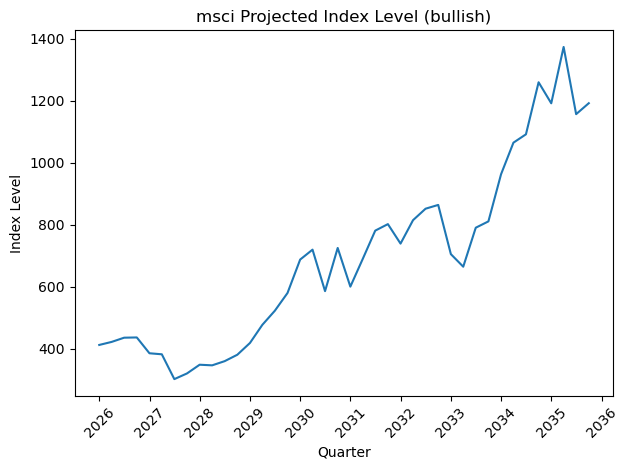

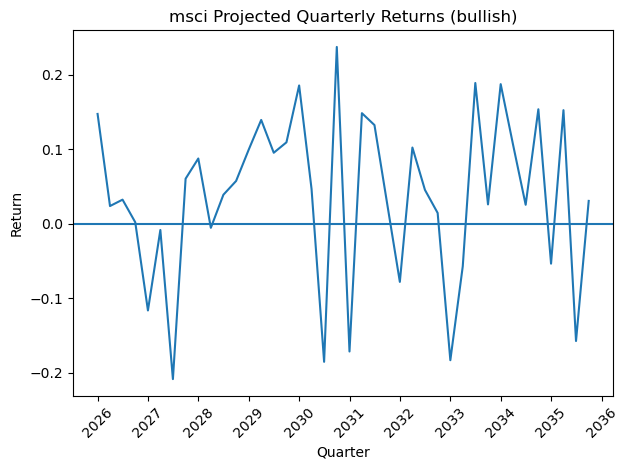

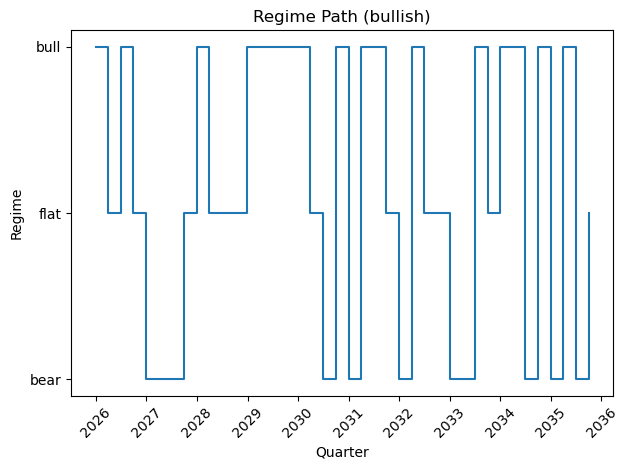

In [154]:
proj["quarter_end"] = pd.to_datetime(proj["quarter_end"])

# 1) Index level
plt.figure()
plt.plot(proj["quarter_end"], proj["index_level"])
plt.title(f"msci Projected Index Level ({scenario})")
plt.xlabel("Quarter")
plt.ylabel("Index Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Quarterly returns
plt.figure()
plt.plot(proj["quarter_end"], proj["msci_ret_q"])
plt.axhline(0)
plt.title(f"msci Projected Quarterly Returns ({scenario})")
plt.xlabel("Quarter")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Regime path
regime_map = {"bear": 0, "flat": 1, "bull": 2}
proj["regime_num"] = proj["regime"].map(regime_map)

plt.figure()
plt.step(proj["quarter_end"], proj["regime_num"], where="post")
plt.yticks([0, 1, 2], ["bear", "flat", "bull"])
plt.title(f"Regime Path ({scenario})")
plt.xlabel("Quarter")
plt.ylabel("Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
